## Importing data from Drive

In [1]:
#There are 6252 images in train and 2680 images in test data. The categories of ships and their corresponding codes in the dataset are as follows -

#{'Cargo': 1, 
#'Military': 2, 
#'Carrier': 3, 
#'Cruise': 4, 
#'Tankers': 5}

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Importing important libraries

In [44]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow_hub as hub
import requests
from PIL import Image
from io import BytesIO
import cv2
from urllib.request import urlopen


## Data Preprocessing

In [3]:
train_labels = pd.read_csv('/content/gdrive/MyDrive/Ship/train/train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/Ship/test_ApKoW4T.csv')


#Adding one more column specifying the type
convertlabeldict = {1: 'Cargo', 
2:'Military', 
3:'Carrier', 
4:'Cruise', 
5:'Tankers'}
train_labels['category_label'] = train_labels['category'].map(convertlabeldict)
train_labels['category'] = train_labels['category'] -1
train_labels.head()



,image,category,category_label
0,2823080.jpg,0,Cargo
1,2870024.jpg,0,Cargo
2,2662125.jpg,1,Military
3,2900420.jpg,2,Carrier
4,2804883.jpg,1,Military


### Defining helper functions

In [41]:
# Converting images into 128x128 pixels
def preprocess_image(image_path):
  ship = image.load_img(image_path , target_size =(128, 128) , interpolation='lanczos')
  ship = image.img_to_array(ship)
  return ship.astype('float32') /255

In [5]:
train_label = []
train_image = []
path = "/content/gdrive/MyDrive/Ship/train/images/"

for i in train_labels.iterrows():
  image_path = os.path.join(path , i[1]['image'])
  train_image.append(preprocess_image(image_path))
  train_label.append(float(i[1]['category']))
train_label = np.asarray(train_label)
train_image = np.asarray(train_image)
train_image.shape, train_label.shape

((6252, 128, 128, 3), (6252,))

### Looking at samples

Cruise


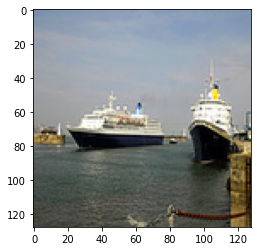

In [11]:
plt.imshow(train_image[1200])
print(train_labels['category_label'][1200])

Cargo


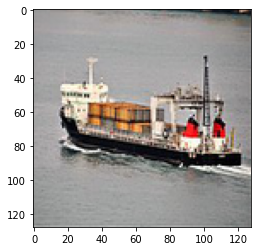

In [12]:
plt.imshow(train_image[1])
print(train_labels['category_label'][1])

### Building the model

In [13]:
model = keras.models.Sequential()
model.add(keras.Input(shape = (128,128,3)))
model.add(keras.applications.MobileNet(include_top = False, weights = 'imagenet'))
model.add(layers.Conv2D(3, 3, padding='same', activation='sigmoid'))
model.add(layers.Flatten())
model.add(layers.Dense(5 , activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, None, None, 1024)  3228864  
 nal)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 3)           27651     
                                                                 
 flatten_1 (Flatten)         (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 245       
                                                                 
Total params: 3,256,760
Trainable params: 3,234,872
Non-trainable params: 21,888
_________________________________________________________________
None


## Training the model

In [14]:
history= model.fit(train_image,
                   train_label,
                   epochs=40,
                   batch_size =200,
                   validation_split = 0.2)

Epoch 1/40
26/26 [==============================] - 14s 381ms/step - loss: 1.3300 - accuracy: 0.4561 - val_loss: 1.0907 - val_accuracy: 0.5667
Epoch 2/40
26/26 [==============================] - 9s 346ms/step - loss: 0.8509 - accuracy: 0.7870 - val_loss: 0.9124 - val_accuracy: 0.7306
Epoch 3/40
26/26 [==============================] - 9s 348ms/step - loss: 0.6960 - accuracy: 0.8762 - val_loss: 0.8100 - val_accuracy: 0.7642
Epoch 4/40
26/26 [==============================] - 9s 355ms/step - loss: 0.6002 - accuracy: 0.9058 - val_loss: 0.7438 - val_accuracy: 0.7898
Epoch 5/40
26/26 [==============================] - 9s 356ms/step - loss: 0.5355 - accuracy: 0.9328 - val_loss: 0.6967 - val_accuracy: 0.8010
Epoch 6/40
26/26 [==============================] - 9s 358ms/step - loss: 0.4864 - accuracy: 0.9418 - val_loss: 0.6469 - val_accuracy: 0.8249
Epoch 7/40
26/26 [==============================] - 9s 366ms/step - loss: 0.4477 - accuracy: 0.9522 - val_loss: 0.6392 - val_accuracy: 0.8233
Epoch

### Plotting the results

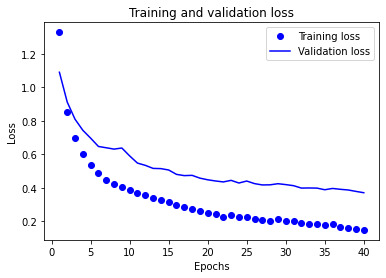

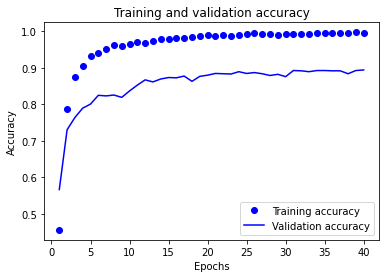

In [15]:
# Loss and accuracy curves
# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# training and validation accuracy 
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Testing the model on some instances of the testing data

In [31]:
all_labels = {'Cargo': 0,
              'Military': 1,
              'Carrier': 2,
              'Cruise': 3,
              'Tankers': 4}
labels = {a:b for b,a in all_labels.items()}

def predict(image):
  prediction = model.predict(np.array([image]))
  prediction_label = np.argsort(prediction)
  for i in prediction_label[0][-1:-3:-1] :
      print(f"{labels[i]} Ship : {prediction[0][i]*100:0.2f} %")

In [21]:
test_image = []
path = "/content/gdrive/MyDrive/Ship/train/images/"

for i in test.iterrows():
  image_path = os.path.join(path , i[1]['image'])
  test_image.append(preprocess_image(image_path))
test_image = np.asarray(test_image)
test_image.shape

(2680, 128, 128, 3)

Cruise Ship : 86.27 %
Military Ship : 4.15 %


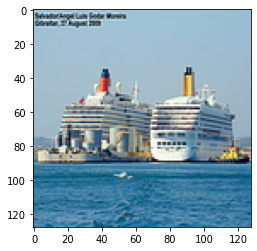

In [32]:
plt.imshow(test_image[1])
predict(test_image[1])

Military Ship : 78.54 %
Cargo Ship : 7.64 %


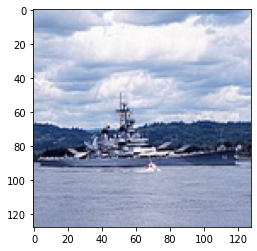

In [34]:
plt.imshow(test_image[50])
predict(test_image[50])

Tankers Ship : 95.51 %
Cargo Ship : 2.65 %


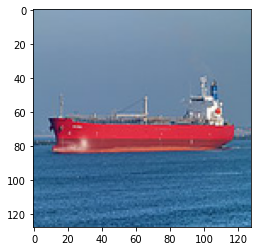

In [35]:
plt.imshow(test_image[1000])
predict(test_image[1000])

Carrier Ship : 91.58 %
Tankers Ship : 5.04 %


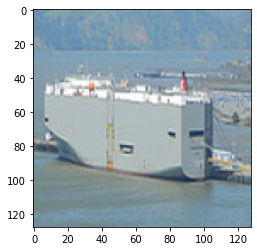

In [37]:
plt.imshow(test_image[1500])
predict(test_image[1500])

Cargo Ship : 93.26 %
Tankers Ship : 3.27 %


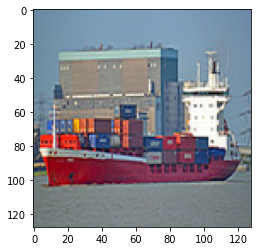

In [38]:
plt.imshow(test_image[2000])
predict(test_image[2000])

## Testing the model on random internet pictures

In [49]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/San_Juan._Carnival_Destiny_cruise_ship._Puerto_Rico_%282749189783%29.jpg/1920px-San_Juan._Carnival_Destiny_cruise_ship._Puerto_Rico_%282749189783%29.jpg?20140418123938


--2022-03-28 17:58:12--  https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/San_Juan._Carnival_Destiny_cruise_ship._Puerto_Rico_%282749189783%29.jpg/1920px-San_Juan._Carnival_Destiny_cruise_ship._Puerto_Rico_%282749189783%29.jpg?20140418123938
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 867387 (847K) [image/jpeg]
Saving to: ‘1920px-San_Juan._Carnival_Destiny_cruise_ship._Puerto_Rico_(2749189783).jpg?20140418123938’

1920px-San_Juan._Ca 100%[===================>] 847.06K  --.-KB/s    in 0.03s   

2022-03-28 17:58:13 (28.2 MB/s) - ‘1920px-San_Juan._Carnival_Destiny_cruise_ship._Puerto_Rico_(2749189783).jpg?20140418123938’ saved [867387/867387]



Cruise Ship : 87.29 %
Carrier Ship : 3.82 %


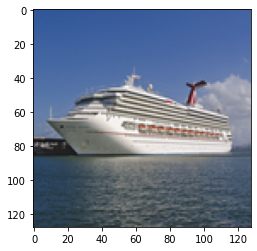

In [52]:
plt.imshow(preprocess_image('/content/1920px-San_Juan._Carnival_Destiny_cruise_ship._Puerto_Rico_(2749189783).jpg?20140418123938'))
predict(preprocess_image('/content/1920px-San_Juan._Carnival_Destiny_cruise_ship._Puerto_Rico_(2749189783).jpg?20140418123938'))

In [55]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/2022-01-09_ELM_K_-_IMO_9614294.jpg/1600px-2022-01-09_ELM_K_-_IMO_9614294.jpg?20220110013501

--2022-03-28 18:01:58--  https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/2022-01-09_ELM_K_-_IMO_9614294.jpg/1600px-2022-01-09_ELM_K_-_IMO_9614294.jpg?20220110013501
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 705652 (689K) [image/jpeg]
Saving to: ‘1600px-2022-01-09_ELM_K_-_IMO_9614294.jpg?20220110013501’

1600px-2022-01-09_E 100%[===================>] 689.11K  --.-KB/s    in 0.02s   

2022-03-28 18:01:58 (29.0 MB/s) - ‘1600px-2022-01-09_ELM_K_-_IMO_9614294.jpg?20220110013501’ saved [705652/705652]



Cargo Ship : 92.47 %
Tankers Ship : 5.38 %


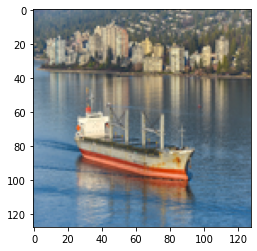

In [56]:
plt.imshow(preprocess_image('/content/1600px-2022-01-09_ELM_K_-_IMO_9614294.jpg?20220110013501'))
predict(preprocess_image('/content/1600px-2022-01-09_ELM_K_-_IMO_9614294.jpg?20220110013501'))

In [57]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/11-06-07_016_LPG_Tanker_VICTORIA_KOSAN_loading_LNG_at_Melkøya.jpg/640px-11-06-07_016_LPG_Tanker_VICTORIA_KOSAN_loading_LNG_at_Melkøya.jpg

--2022-03-28 18:03:01--  https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/11-06-07_016_LPG_Tanker_VICTORIA_KOSAN_loading_LNG_at_Melk%C3%B8ya.jpg/640px-11-06-07_016_LPG_Tanker_VICTORIA_KOSAN_loading_LNG_at_Melk%C3%B8ya.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84363 (82K) [image/jpeg]
Saving to: ‘640px-11-06-07_016_LPG_Tanker_VICTORIA_KOSAN_loading_LNG_at_Melkøya.jpg’

640px-11-06-07_016_ 100%[===================>]  82.39K  --.-KB/s    in 0.003s  

2022-03-28 18:03:01 (28.4 MB/s) - ‘640px-11-06-07_016_LPG_Tanker_VICTORIA_KOSAN_loading_LNG_at_Melkøya.jpg’ saved [84363/84363]



Tankers Ship : 91.94 %
Cargo Ship : 6.02 %


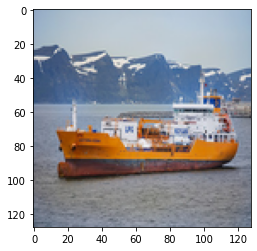

In [58]:
plt.imshow(preprocess_image('/content/640px-11-06-07_016_LPG_Tanker_VICTORIA_KOSAN_loading_LNG_at_Melkøya.jpg'))
predict(preprocess_image('/content/640px-11-06-07_016_LPG_Tanker_VICTORIA_KOSAN_loading_LNG_at_Melkøya.jpg'))